In [13]:
%matplotlib notebook
import numpy as np
import sys
sys.path.insert(0,'..')
import emlddmm
from emlddmm import read_data, interp
import dti
import matplotlib.pyplot as plt
import os
import h5py
import torch
import pandas as pd
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from skimage.transform import resize
from skimage.color import hsv2rgb, rgb2gray
from skimage.morphology import ball, opening


jacobian = lambda X,dv : np.stack(np.gradient(X, dv[0],dv[1],dv[2], axis=(0,1,2)), axis=-1)

In [14]:
# file paths

hist_to_mri_path = '/home/brysongray/data/human_amyg/amyg_maps_for_bryson/registered_histology_to_mri_displacement.vtk'
dti_path = '/home/brysongray/data/dki/dki_tensor.nii.gz'
mri_to_hist_path = '/home/brysongray/data/human_amyg/amyg_maps_for_bryson/mri_avg_b0_to_registered_histology.vtk'
st_path = '/home/brysongray/data/human_amyg/sta_output'
nissl_myelin_rigid = '/home/brysongray/data/human_amyg/nissl_myelin_rigid'
reg_to_input = '/home/brysongray/data/human_amyg/amygdala_outputs_v00/registered_histology/input_histology_to_registered_histology/transforms'
out = '../outputs/'

In [3]:
# for plotting
# slice = 235
slice = 175

## Transform DTI to HIST REGISTERED SPACE

In [15]:
# load disp and original image
xJ,hist_to_mri,_,_ = read_data(hist_to_mri_path)
xI,I,title,_ = read_data(mri_to_hist_path)

dx = np.array([(x[1] - x[0]) for x in xI])
# get transformed coordinates
XI = np.stack(np.meshgrid(xI[0],xI[1],xI[2], indexing='ij'))

X = hist_to_mri[0] + XI

<IPython.core.display.Javascript object>


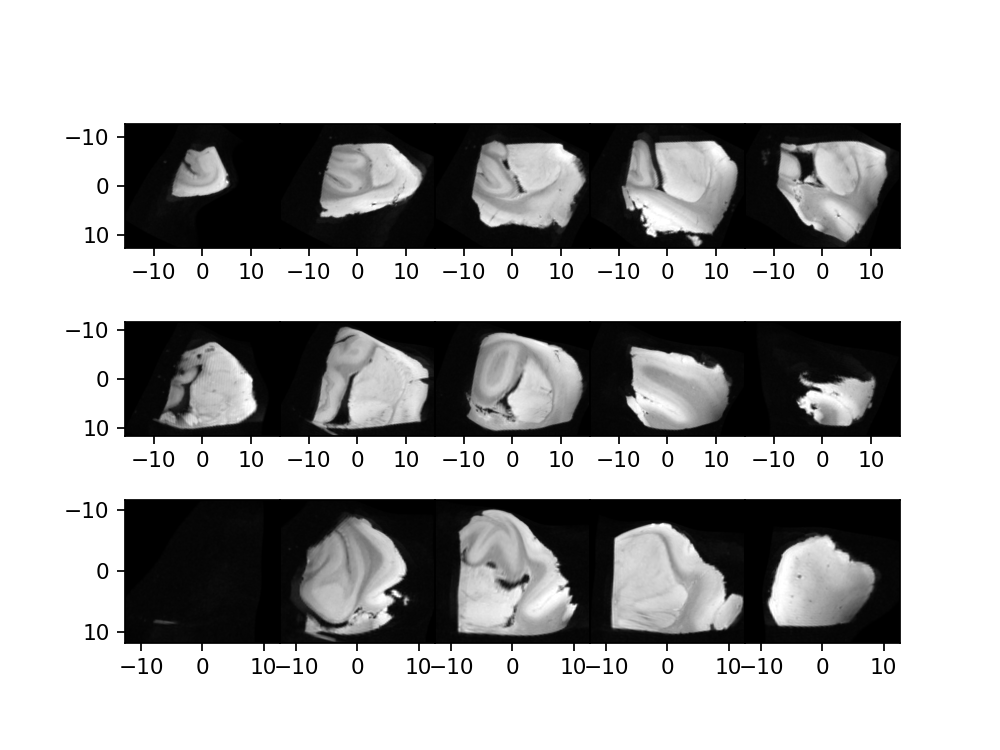

In [5]:
fig, ax = emlddmm.draw(I,xI, cmap='gray', n_slices=5)

In [6]:
I.shape

(1, 293, 216, 270)

In [7]:
plt.figure()
plt.imshow(I[0,slice])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


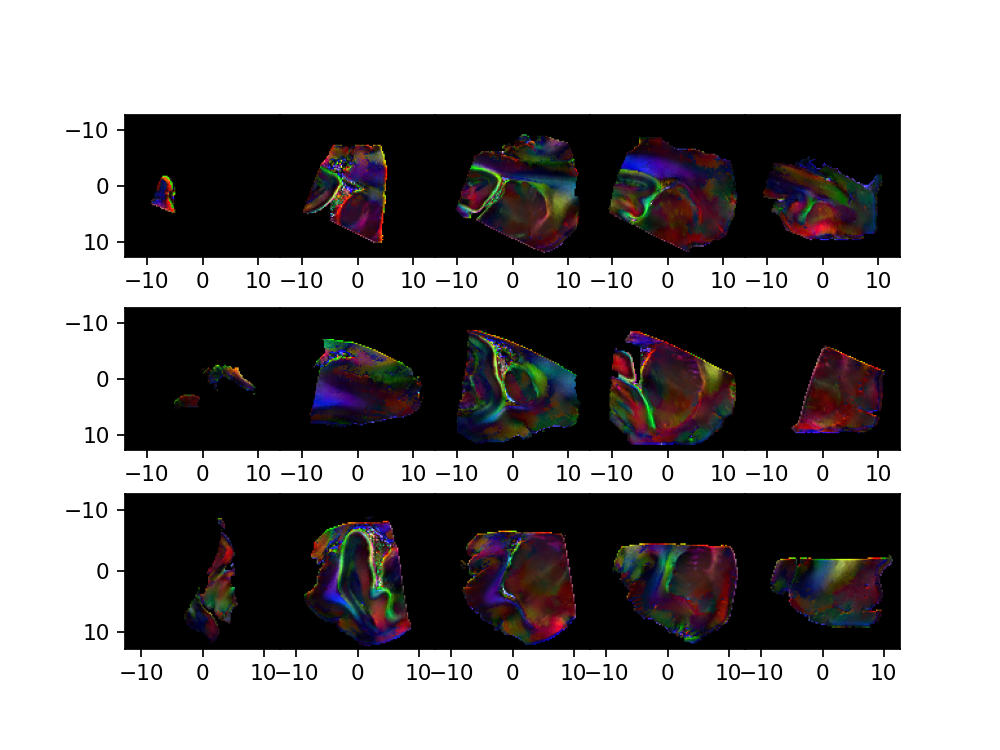

In [8]:
# read dti
xT, T = dti.read_dti(dti_path)
dti.visualize(T,xT)
# transpose and switch components to match histology space orientation
T = np.stack((T[...,0,0],T[...,1,1],T[...,2,2],T[...,0,1],T[...,0,2],T[...,1,2]),-1)
T = np.stack((T[...,1],T[...,3],T[...,5],T[...,3],T[...,0],T[...,4],T[...,5],T[...,4],T[...,2]), axis=-1).transpose(1,0,2,3)
# T = T.transpose(1,0,2,3,4)
T = T.reshape(T.shape[:3]+(3,3))
xT = [xT[1], xT[0], xT[2]]
dti_original = dti.visualize(T,xT)



### resample dti in registered space and apply ppd to rotate tensors 

In [9]:
# resample dti in registered histology space
Tnew = dti.interp_dti(T,xT,X)
# rotate tensors
J = jacobian(X.transpose(1,2,3,0),dx)
Q = dti.ppd(Tnew,J)
Tnew = Q @ Tnew @ Q.transpose(0,1,2,4,3)

<IPython.core.display.Javascript object>


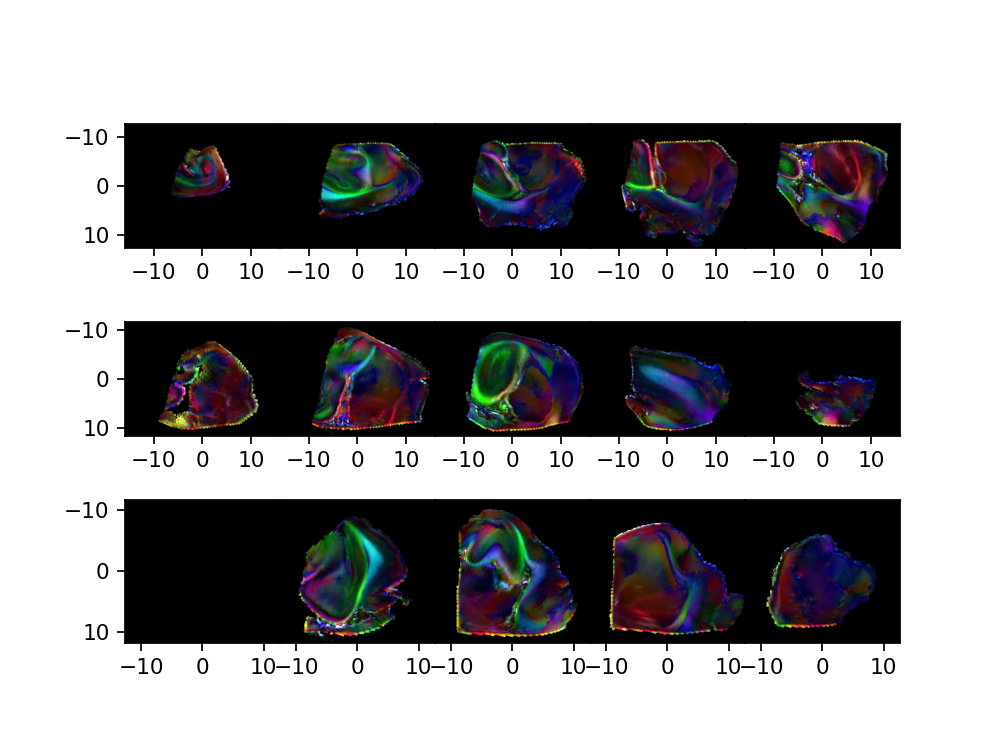

<IPython.core.display.Javascript object>


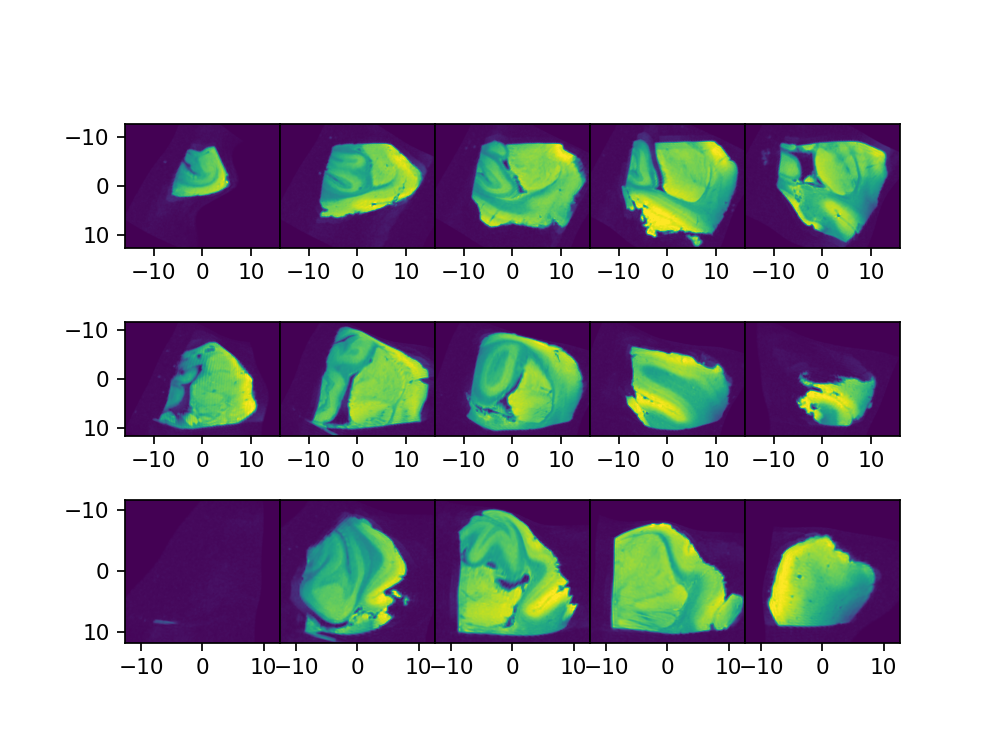

<IPython.core.display.Javascript object>


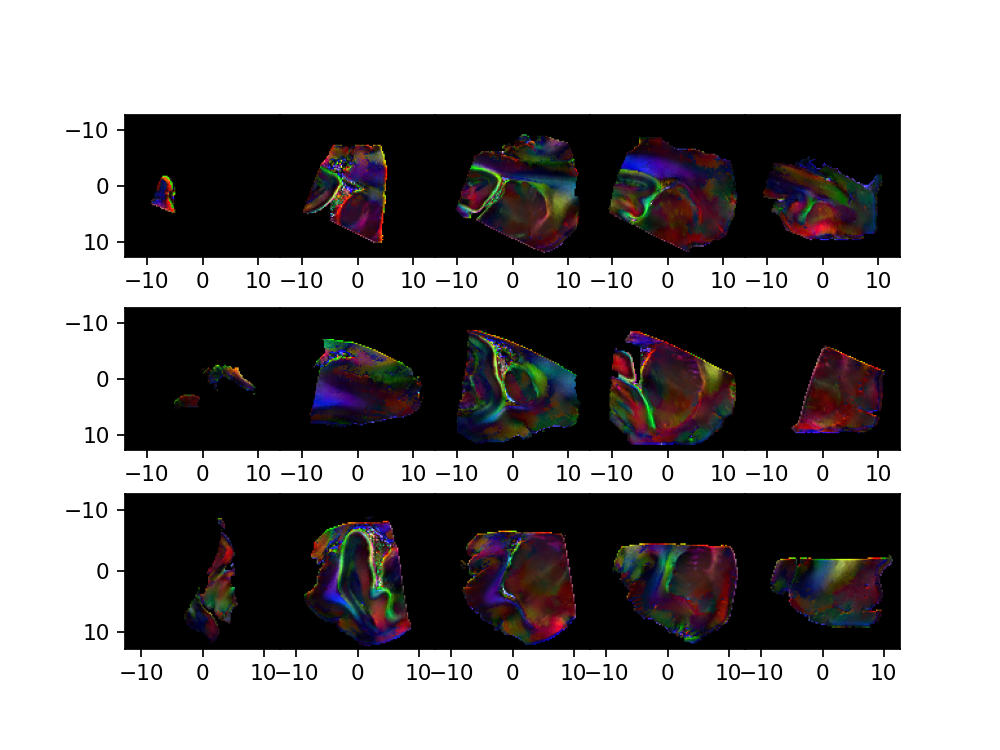

In [10]:
# visualize transformed dti
fig1 = plt.figure()
dti_to_hist = dti.visualize(Tnew,xI,fig=fig1)

# visualize avg b0 in registered histology space
fig2 = plt.figure()
emlddmm.draw(I,xI,fig2)

# visualize original dti
fig3 = plt.figure()
T_img = dti.visualize(T,xT,fig=fig3)

In [14]:
fig, ax = emlddmm.draw(dti_to_hist, xJ=xI)
for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].set_xticks([])
        ax[i][j].set_xticklabels([])
        ax[i][j].set_yticks([])
        ax[i][j].set_yticklabels([])
        

<IPython.core.display.Javascript object>

In [15]:
plt.savefig('/home/brysongray/Downloads/dti_orientations_fig.png')

In [17]:
# save transformed tensors
T_name = 'dti_to_registered_histology.h5'
out = '../outputs/'
with h5py.File(os.path.join(out, T_name), 'w') as f:
        f.create_dataset('DTI transformed', data=Tnew)

BlockingIOError: [Errno 11] Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

## Transform structure tensor images to HIST REGISTERED SPACE
### Get list of structure tensor files that match numbers on nissl_to_myelin transforms

In [16]:

# load structure tensors
# get only slices that match numbers on rigid transforms
# list of transform numbers
nissl_to_myelin_paths = [x for x in os.listdir(nissl_myelin_rigid) if 'npz' in x] # get paths
nissl_to_myelin_paths = sorted(nissl_to_myelin_paths, key=lambda x: int(x.split('_')[-4])) # sort paths
nissl_to_myelin_nums = [x.split('_')[-4] for x in nissl_to_myelin_paths]

st_list = [x for x in os.listdir(st_path) if 'h5' in x]
st_list = sorted(st_list, key=lambda x: x.split('_')[-3])
st_list_nums = [x.split('_')[-3] for x in st_list]

reg_to_input_paths = sorted(os.listdir(reg_to_input), key=lambda x: int(x.split('_')[-2])) # list and sort paths
reg_to_input_nums = [x.split('_')[-2] for x in reg_to_input_paths]

# intersection of three lists: myelin series (291), nissl to myelin transforms (275), registered to input transforms (280)
ind_dict = dict((k,i) for i,k in enumerate(st_list_nums)) # index:slicenumber dictionary 
indices = [ind_dict[x] for x in list(nissl_to_myelin_nums)] # indices in the st_list corresponding to the intersection
st_list_x = np.array(st_list)[indices] # filenames at intersection indices


In [17]:
st_list_x[175]

'MD847-My86-2021.12.14-09.16.22_MD847_1_0256_lossy_S.h5'

In [5]:
fname = st_list_x[slice]
with h5py.File(os.path.join(st_path,fname),'r') as f:
    img = f[list(f.keys())[0]][:]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### load tensors from list

In [18]:
S_ = []
nS_ = np.zeros((len(st_list_x),3), dtype=int)
dS = np.array([80.0,117.76,117.76]) # 0.46 * 2**8 = 117.76
for i in range(len(st_list_x)):
    fname = st_list_x[i]
    with h5py.File(os.path.join(st_path,fname),'r') as f:
        img = f[list(f.keys())[0]][:]
    # combine 2x2 structure tensors into one dimension (xx,xy,yy)
    S__ = np.stack((img[...,1,1], img[...,0,1], img[...,0,0]),axis=-1) # note structure tensors are saved in xy not row-column format
                                                                       # I will change back to row-column here
    # downsample image
    S__ = emlddmm.downsample(S__,[8,8,1])
    nS_[i] = np.array(S__.shape)
    S_.append(S__)

# pad images
nSm = np.max(nS_,0)
nSm = (np.quantile(nS_,0.95,axis=0)*1.01).astype(int) 
print('padding and assembling into 3D volume')
S = np.zeros((len(S_),nSm[0],nSm[1],3), dtype=np.float32)
for i in range(len(S_)):
    S__ = S_[i]
    topad = nSm - np.array(nS_[i])
    # just pad on the left and I'll fill it in
    topad = np.array(((topad[0]//2,0),(topad[1]//2,0),(0,0)))
    # if there are any negative values I need to crop, I'll just crop on the right
    if np.any(np.array(topad)<0):
        if topad[0][0] < 0:
            S__ = S__[:S.shape[1]]
            topad[0][0] = 0
        if topad[1][0] < 0:
            S__ = S__[:,:S.shape[2]]
            topad[1][0] = 0
    Sp = np.pad(S__,topad,constant_values=np.nan)
    Sp[np.isnan(Sp)] = 0
    S[i,:Sp.shape[0],:Sp.shape[1],:] = Sp
S = np.transpose(S,(3,0,1,2))
nS = np.array(S.shape)
xS = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nS[1:],dS)]

del S_, S__, Sp,img

padding and assembling into 3D volume


In [7]:
emlddmm.draw(S[0][None], xS)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 [[<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>],
  [<AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>,
   <AxesSubplot:>]])

### load and compose 2d transforms

In [19]:
# load rigid nissl to myelin transforms
reg_to_input_ind_dict = dict((k,i) for i,k in enumerate(reg_to_input_nums))
indices = [reg_to_input_ind_dict[x] for x in list(nissl_to_myelin_nums)]
reg_to_input_paths_x = np.array(reg_to_input_paths)[indices]

NtoMy_A2d = []
for path in nissl_to_myelin_paths:
    A2d_ = np.load(os.path.join(nissl_myelin_rigid,path))['arr_0']
    NtoMy_A2d.append(A2d_)

# Registered to myelin transforms are composition of nissl_to_myelin and registered_to_input
A2d = []
for i in range(len(reg_to_input_paths_x)):
        A2d_ = np.genfromtxt(os.path.join(reg_to_input, reg_to_input_paths_x[i]), delimiter=' ')
        # note that there are nans at the end if I have commas at the end
        if np.isnan(A2d_[0, -1]):
            A2d_ = A2d_[:, :A2d_.shape[1] - 1]
        # 'xy' -> 'ij'
        A2d_[:3] = A2d_[:3][::-1]
        A2d_[:, :3] = A2d_[:,:3][:,::-1]
        A2d_ = A2d_[1:,1:]
        # compose transforms by multiplying arrays nissl_to_myelin * registered_to_input
        A2d_ = NtoMy_A2d[i] @ A2d_
        A2d_[:2,-1] = A2d_[:2,-1]*1000 # convert mm to microns
        A2d.append(A2d_)

In [20]:
len(A2d)

275

## get subset of registered points to resample myelin

In [21]:
file_to_idx_csv = pd.read_csv('/home/brysongray/diffusion_analysis/files_for_bryson.csv', header=None)
file_to_idx = file_to_idx_csv.to_numpy()

for i in reversed(range(file_to_idx.shape[0])):
    if file_to_idx[i,1] == 'None':
        I = np.delete(I, int(file_to_idx[i,0]), 1)
    elif file_to_idx[i,1].split('_')[-1][:-4] not in nissl_to_myelin_nums:
        I = np.delete(I, int(file_to_idx[i,0]), 1)

### apply registered to myelin transform to registered points and resample structure tensors

In [25]:
print(points.shape)
print(S.shape)
print([x.shape for x in xS])

torch.Size([3, 275, 216, 270])
(3, 275, 213, 257)
[(275,), (213,), (257,)]


In [22]:
# apply registered to myelin transform to registered points
A2d = torch.as_tensor(np.stack(A2d))#,dtype=dtype,device=device)
XI_ = XI.transpose(1,2,3,0)*1000
points = (A2d[:, None, None, :2, :2] @ XI_[:A2d.shape[0], ..., 1:, None])[..., 0] + A2d[:, None, None, :2, -1]
points = points.permute(-1,0,1,2)
points = torch.cat((torch.ones_like(points[0])[None]*xS[0][None,:,None,None], points))

# Sr = emlddmm.interp(xS, S, points.float())
# emlddmm.draw(Sr,xS)

# # stack component into tensors
# Sr = torch.stack((Sr[0], Sr[1], Sr[1], Sr[2]), dim=-1)
# Sr = Sr.reshape(Sr.shape[:3] + (2,2)).detach().numpy()

In [26]:
# write out registered structure tensors
st_name = 'structure_tensors_to_registered_histology.h5'
with h5py.File(os.path.join(out, st_name), 'w') as f:
        f.create_dataset('sta registered', data=Sr)

BlockingIOError: [Errno 11] Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [27]:
Sr_ = h5py.File(os.path.join(out, 'structure_tensors_to_registered_histology.h5'), 'r')
Sr = np.array(Sr_[list(Sr_.keys())[0]])

OSError: Unable to open file (file signature not found)

### get structure tensor minor eigenvectors

In [29]:
# get principle orientations
w,e = np.linalg.eigh(Sr)

st_eig_ = e[...,0] # this is the eigenvector corresponding to the smallest eigenvalue
# st_eig_ = st_eig_*np.array([1,-1])

In [28]:
Sr.shape

(275, 216, 270, 2, 2)

In [81]:
st_eig_[137,108,130:135]

array([[-0.97626364,  0.21658558],
       [-0.99781084,  0.066133  ],
       [-0.84752679, -0.53075266],
       [-0.13647838,  0.99064302],
       [-0.67218995,  0.74037874]])

In [82]:
# rotate eigenvectors
Arot = A2d[:,:2,:2]
st_eig = (Arot[:,None,None] @ st_eig_[...,None]).squeeze().detach().numpy()

In [83]:
st_angles = np.arctan(st_eig[...,0]/st_eig[...,1])# + np.pi/2 # arctan(row/column)
# st_angles = np.where(st_angles < 0, st_angles + np.pi, st_angles) # make between 0 and pi
print(f'st_angles are between: {np.min(st_angles)} and {np.max(st_angles)}')

st_angles are between: -1.570795888668914 and 1.5707960188098096


In [84]:
# write out myelin angles
fname = 'myelin_to_registered_angles.vtk'
out = '../outputs/'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,st_angles[None],'structure_tensor_angles')

## GET DTI ORIENTATIONS

In [32]:
# load dti_to_registered_histology from file
T_path = '/home/brysongray/diffusion_analysis//outputs/dti_to_registered_histology.h5'
T_ = h5py.File(T_path, 'r')
Tnew = np.array(T_[list(T_.keys())[0]])

In [85]:
xS, st_angles, _, _ = emlddmm.read_data(os.path.join(out,'myelin_to_registered_angles.vtk'))
st_angles = st_angles[0]

### Get tensor principle eigenvectors


In [37]:
# Get FA from tensors
# Get tensor principle eigenvectors
w_, e = np.linalg.eigh(Tnew)
dti_eig = e[...,-1]
# dti_eig = dti_eig[...,[0,2,1]]
# only slices in nissl_to_myelin series
dti_eig_small = []
for i in range(file_to_idx.shape[0]):
    if file_to_idx[i,1] != 'None' and file_to_idx[i,1].split('_')[-1][:-4] in nissl_to_myelin_nums:
        dti_eig_small.append(dti_eig[file_to_idx[i,0]])
dti_eig_small = np.stack(dti_eig_small)

In [38]:
trace = np.trace(Tnew, axis1=-2, axis2=-1)
# transpose to C x nslice x nrow x ncol
w = w_.transpose(3,0,1,2)
FA = np.sqrt((3/2) * (np.sum((w - (1/3)*trace)**2,axis=0) / np.sum(w**2, axis=0)))
FA = np.nan_to_num(FA)
FA = FA/np.max(FA)
# makes sizes match
FA_small = []
for i in range(file_to_idx.shape[0]):
    if file_to_idx[i,1] != 'None' and file_to_idx[i,1].split('_')[-1][:-4] in nissl_to_myelin_nums:
        FA_small.append(FA[file_to_idx[i,0]])
FA_small = np.stack(FA_small)

In [40]:
# save FA
np.save('/home/brysongray/diffusion_analysis/outputs/amyg_dti_FA',FA)

<IPython.core.display.Javascript object>


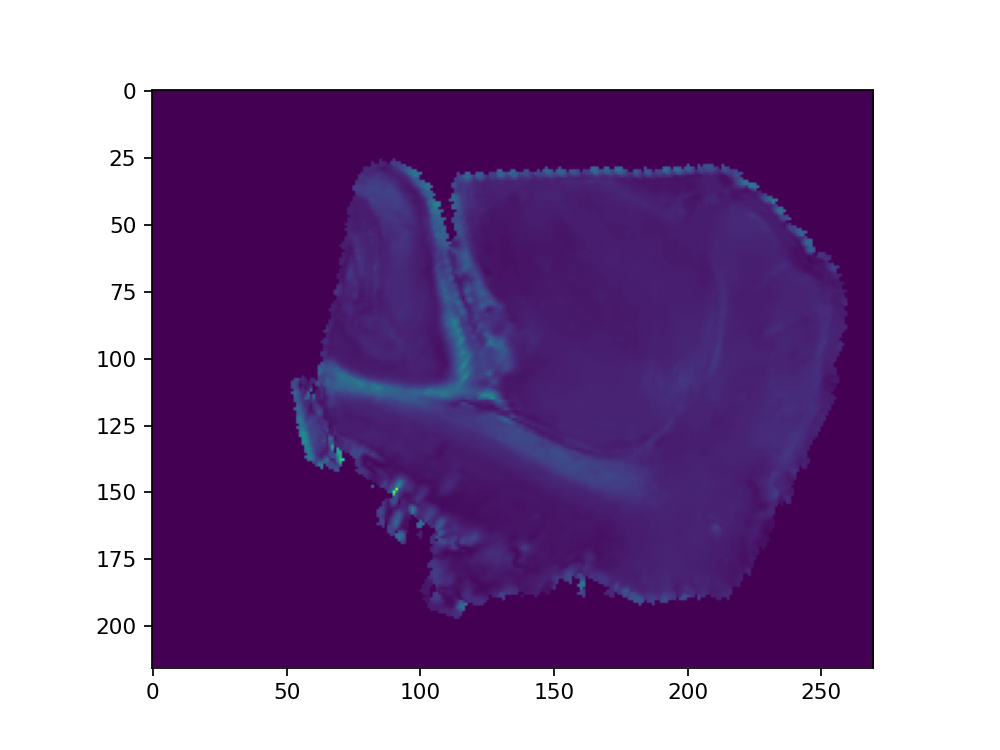

In [41]:
plt.figure()
plt.imshow(FA_small[slice])

### make masks

In [42]:
slice = 100
# mask out brain from T2 image
brain_thresh = 1.5e3
brain_mask = np.where(I[0] >= brain_thresh, 1.0, 0.0)

# create mask based on FA threshold
FA_thresh = 0.125
FA_mask_small = np.where(FA_small >= FA_thresh, 1.0, 0.0)

WM = FA_mask_small * brain_mask
GM = brain_mask - WM
# binary opening on masks
footprint = ball(2)

WM_open = opening(WM, footprint)
GM_open = opening(GM, footprint)

<IPython.core.display.Javascript object>


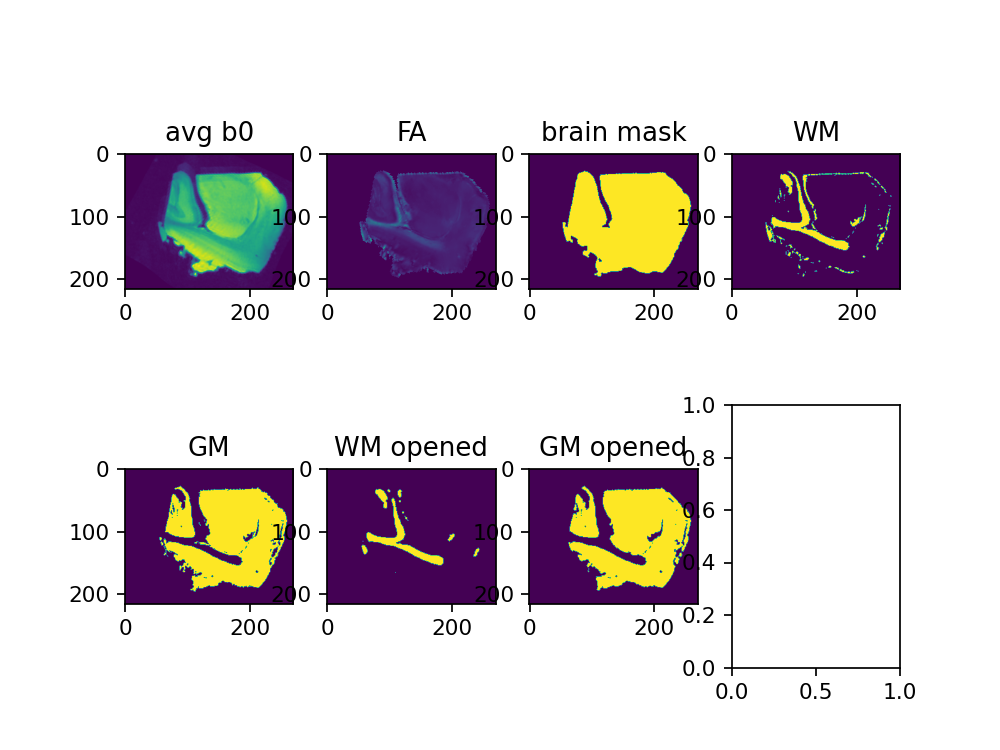

Text(0.5, 1.0, 'GM opened')

In [43]:
slice = 175

fig, axs = plt.subplots(nrows=2, ncols=4)

axs[0,0].imshow(I[0,slice])
axs[0,0].set_title('avg b0')
axs[0,1].imshow(FA_small[slice])
axs[0,1].set_title('FA')
axs[0,2].imshow(brain_mask[slice])
axs[0,2].set_title('brain mask')
axs[0,3].imshow(WM[slice])
axs[0,3].set_title('WM')
axs[1,0].imshow(GM[slice])
axs[1,0].set_title('GM')
axs[1,1].imshow(WM_open[slice])
axs[1,1].set_title('WM opened')
axs[1,2].imshow(GM_open[slice])
axs[1,2].set_title('GM opened')

In [44]:
WM = WM_open
GM = GM_open

In [46]:
toshow = np.array(FA_small[slice])
toshow[np.logical_not(brain_mask[slice])] = np.nan
fig = plt.figure()
plt.imshow(toshow)

fname = 'FA.png'
out = '/home/brysongray/diffusion_analysis/outputs/'
plt.imsave(os.path.join(out,fname),np.array(toshow), vmin=np.min(FA_small[slice]*brain_mask[slice]), vmax=np.max(FA_small[slice]*brain_mask[slice]), cmap='gray')

<IPython.core.display.Javascript object>

### loop through permutations of structure tensors and diffusion tensors to find best agreement

In [86]:
total_agreement = []
permutation = []
for structure_perm in [[0,1],[1,0]]:
    Sp = st_eig[...,structure_perm]
    for flip_S in [[1,1],[-1,1],[1,-1]]:
        Sp_flip = Sp*np.array(flip_S)
        for diffusion_perm in [[0,1,2],[0,2,1],[1,0,2],[1,2,0],[2,0,1],[2,1,0]]:
            Tp = dti_eig_small[...,diffusion_perm]
            # look at the absolute value of dot product
            Tp2d = Tp[...,[1,2]]
            Tp2d = Tp2d / np.sqrt(np.sum(Tp2d**2,-1,keepdims=True))
            Tp2d = np.nan_to_num(Tp2d)
            for flip_T in [[1,1],[-1,1],[1,-1]]:
                Tp2d_flip = Tp2d*np.array(flip_T)
                agreement = np.abs(np.sum(Sp_flip * Tp2d_flip,-1)) # give the cos of the positive angle between them
                # find the total amount of agreement in wm  
                total_agreement.append(np.sum(agreement*WM)/np.sum(WM)) # -> we want this number to be close to 1
                permutation.append([structure_perm, diffusion_perm, flip_S,flip_T])
        # save this value for each permutation
        # figure out which is the biggest, and then we’ll look at that

In [49]:
print(np.argmax(total_agreement), total_agreement[np.argmax(total_agreement)])
print(permutation[np.argmax(total_agreement)])

6 0.81081822141804
[[0, 1], [1, 0, 2], [1, 1], [1, 1]]


In [50]:
# apply permutation
dti_eig = dti_eig[...,[1,0,2]]
dti_eig_small = dti_eig_small[...,[1,0,2]]

In [87]:
print(np.argmax(total_agreement), total_agreement[np.argmax(total_agreement)])
print(permutation[np.argmax(total_agreement)])

0 0.8066160695616805
[[0, 1], [0, 1, 2], [1, 1], [1, 1]]


In [71]:
# apply permutation
dti_eig = dti_eig*np.array([1,-1,1])
dti_eig_small = dti_eig_small*np.array([1,-1,1])

### get diffusion tensor in-plane angles

In [88]:
dti_angles = np.arctan(dti_eig_small[...,1]/dti_eig_small[...,2])
# dti_angles = np.where(dti_angles < 0, dti_angles + np.pi, dti_angles) # make between 0 and pi
print(f'dti_angles are between: {np.min(dti_angles)} and {np.max(dti_angles)}')

dti_angles are between: -1.5707940824651367 and 1.5707950060840972


In [89]:
# write out dti angles
fname = 'dti_to_registered_angles.vtk'
out = '../outputs/'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,dti_angles[None],'dti_angles')

### Get FA from tensors


### in and out of plane masks

<IPython.core.display.Javascript object>


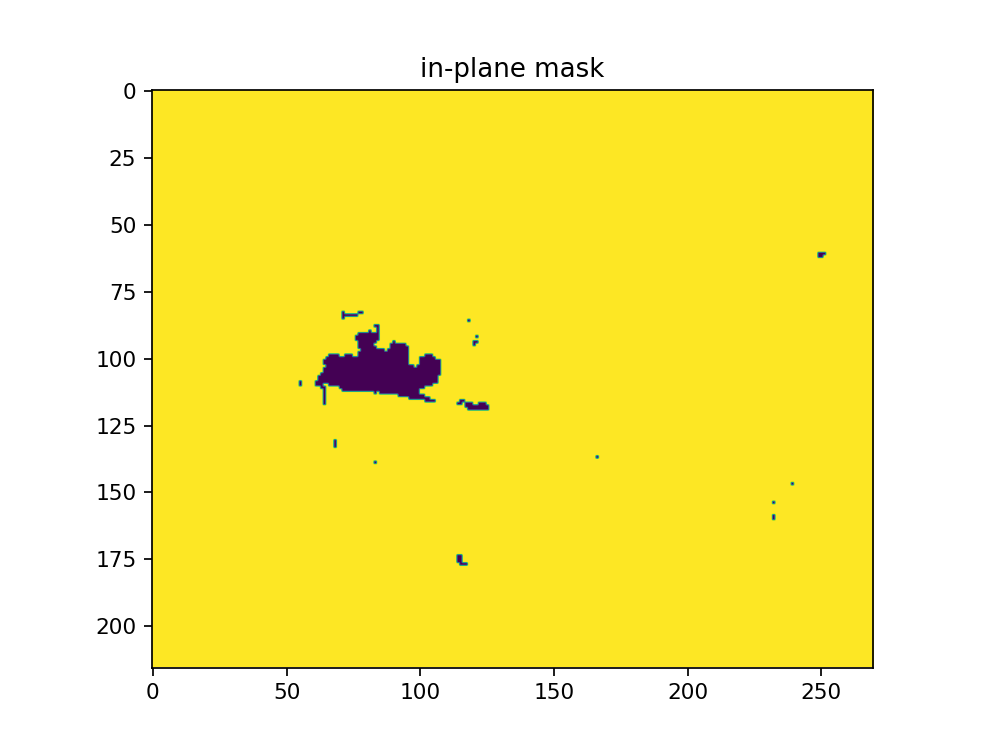

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


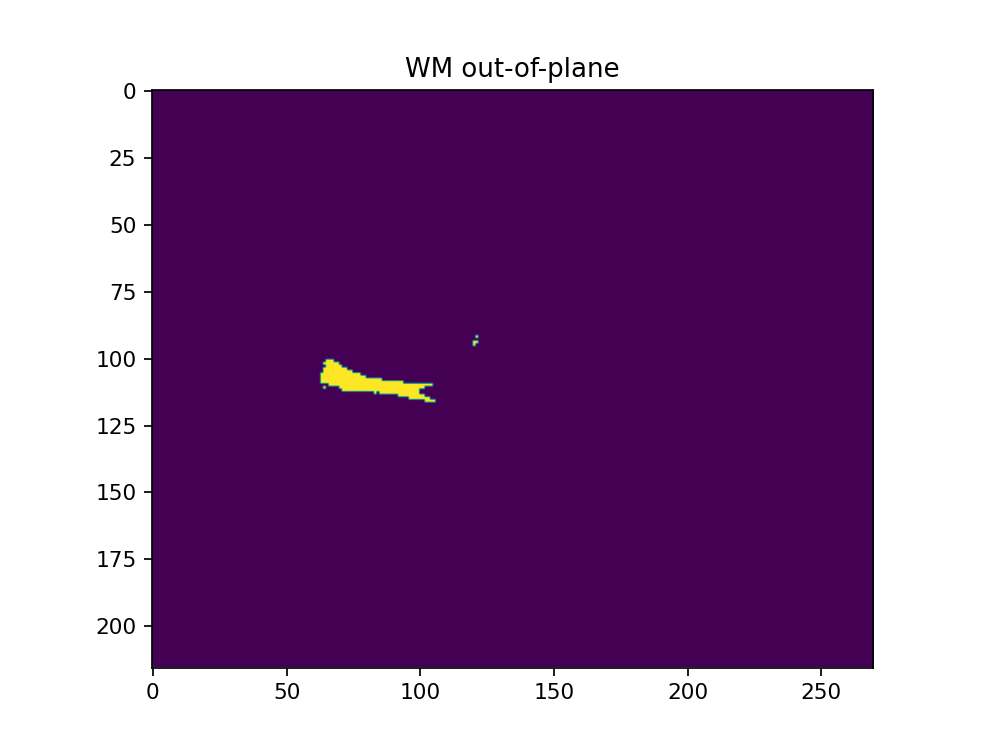

<IPython.core.display.Javascript object>


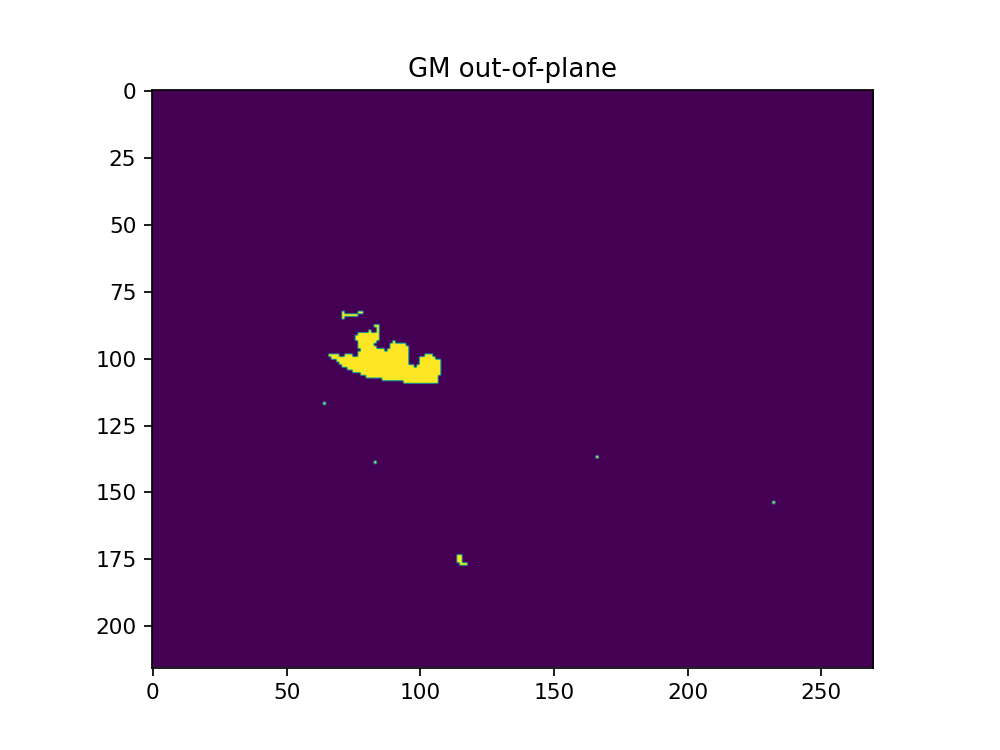

Text(0.5, 1.0, 'GM out-of-plane')

In [90]:
# mask based on out-of-slice angle
# slices correspond to the first component
theta_thresh = np.pi/3
theta = np.abs(np.arcsin(dti_eig_small[...,0]))
theta_mask = np.where(theta <= theta_thresh, 1.0, 0.0)

fig = plt.figure()
plt.imshow(theta_mask[slice])
plt.title('in-plane mask')


WM_in = WM * theta_mask
WM_out = WM - WM_in
GM_in = GM * theta_mask
GM_out = GM - GM_in
fig = plt.figure()
plt.imshow(WM_in[slice])
plt.title('WM in-plane')
fig = plt.figure()
plt.imshow(GM_in[slice])
plt.title('GM in-plane')
fig = plt.figure()
plt.imshow(WM_out[slice])
plt.title('WM out-of-plane')
fig = plt.figure()
plt.imshow(GM_out[slice])
plt.title('GM out-of-plane')

# save out
# emlddmm.write_vtk_data('output_images/WM_in.vtk', xS, WM_in[None], title='WM_in')
# emlddmm.write_vtk_data('output_images/GM_in.vtk', xS, GM_in[None], title='GM_in')
# emlddmm.write_vtk_data('output_images/WM_out.vtk', xS, WM_out[None], title='WM_out')
# emlddmm.write_vtk_data('output_images/GM_out.vtk', xS, GM_out[None], title='GM_out')
# emlddmm.write_vtk_data('output_images/brain_mask.vtk', xS, brain_mask[None], title='brain_mask')

### find agreement between dti and structure tensor vectors as angles in degree

In [91]:
dti2d = dti_eig_small[...,[1,2]]
dti2d = dti2d / np.sqrt(np.sum(dti2d**2,-1,keepdims=True))
dti2d = np.nan_to_num(dti2d)

agreement = np.abs(np.sum(st_eig * dti2d,-1))
agreement = np.nan_to_num(np.arccos(agreement), 0.0) * 180 / np.pi

print(f'agreement is between {np.min(agreement)} and {np.max(agreement)}')

agreement_WM_in = agreement*WM_in
agreement_GM_in = agreement*GM_in
agreement_WM_out = agreement*WM_out
agreement_GM_out = agreement*GM_out
agreement_brain = agreement*brain_mask

agreement is between 0.0 and 89.99997489723104


In [92]:
out = '../outputs/'

fname = 'agreement_WM_in.vtk'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,agreement_WM_in[None],'agreement_WM_in')
fname = 'agreement_GM_in.vtk'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,agreement_GM_in[None],'agreement_GM_in')
fname = 'agreement_WM_out.vtk'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,agreement_WM_out[None],'agreement_WM_out')
fname = 'agreement_GM_out.vtk'
emlddmm.write_vtk_data(os.path.join(out,fname),xS,agreement_GM_out[None],'agreement_GM_out')

### mean and std of agreement in degrees (0 is perfect alignment)

In [93]:
mean_agreement_WM_in = np.sum(agreement_WM_in)/np.sum(WM_in)
mean_agreement_WM_out = np.sum(agreement_WM_out)/np.sum(WM_out)
mean_agreement_GM_in = np.sum(agreement_GM_in)/np.sum(GM_in)
mean_agreement_GM_out = np.sum(agreement_GM_out)/np.sum(GM_out)

std = lambda x, u, mask: np.sqrt(np.sum((x - mask*u)**2) / np.sum(mask))

std_agreement_WM_in = std(agreement_WM_in, mean_agreement_WM_in, WM_in)
std_agreement_WM_out = std(agreement_WM_out, mean_agreement_WM_out, WM_out)  
std_agreement_GM_in = std(agreement_GM_in, mean_agreement_GM_in, GM_in)
std_agreement_GM_out = std(agreement_GM_out, mean_agreement_GM_out, GM_out)

temp = np.array(agreement_WM_in)
temp[np.logical_not(WM_in)] = np.nan
median_agreement_WM_in = np.nanmedian(temp)
temp = np.array(agreement_WM_out)
temp[np.logical_not(WM_out)] = np.nan
median_agreement_WM_out = np.nanmedian(temp)
temp = np.array(agreement_GM_in)
temp[np.logical_not(GM_in)] = np.nan
median_agreement_GM_in = np.nanmedian(temp)
temp = np.array(agreement_GM_out)
temp[np.logical_not(GM_out)] = np.nan
median_agreement_GM_out = np.nanmedian(temp)

MAE = lambda x, u, mask: np.sum(np.abs(x - mask*u))/np.sum(mask)

MAE_agreement_WM_in = MAE(agreement_WM_in, median_agreement_WM_in, WM_in)
MAE_agreement_WM_out = MAE(agreement_WM_out, median_agreement_WM_out, WM_out)  
MAE_agreement_GM_in = MAE(agreement_GM_in, median_agreement_GM_in, GM_in)
MAE_agreement_GM_out = MAE(agreement_GM_out, median_agreement_GM_out, GM_out)

In [47]:
print(mean_agreement_WM_in, std_agreement_WM_in,'\n',
      mean_agreement_WM_out, std_agreement_WM_out,'\n',
      mean_agreement_GM_in, std_agreement_GM_in,'\n',
      mean_agreement_GM_out, std_agreement_GM_out)

27.02285471835299 24.085996507167867 
 38.784058606695076 26.372233644836093 
 35.2216569975562 25.839528986823645 
 38.6922925403688 26.132782657941696


In [78]:
print(mean_agreement_WM_in, std_agreement_WM_in,'\n',
      mean_agreement_WM_out, std_agreement_WM_out,'\n',
      mean_agreement_GM_in, std_agreement_GM_in,'\n',
      mean_agreement_GM_out, std_agreement_GM_out)

28.004410866243457 23.598664823329013 
 38.81913312267132 26.36207997350604 
 35.49032947761077 25.73915932086744 
 38.5062195103823 26.101288794941023


In [94]:
print(mean_agreement_WM_in, std_agreement_WM_in,'\n',
      mean_agreement_WM_out, std_agreement_WM_out,'\n',
      mean_agreement_GM_in, std_agreement_GM_in,'\n',
      mean_agreement_GM_out, std_agreement_GM_out)

28.004410866243457 23.598664823329013 
 38.81913312267132 26.36207997350604 
 35.49032947761077 25.73915932086744 
 38.5062195103823 26.101288794941023


In [48]:
print(median_agreement_WM_in, MAE_agreement_WM_in,'\n',
      median_agreement_WM_out, MAE_agreement_WM_out,'\n',
      median_agreement_GM_in, MAE_agreement_GM_in,'\n',
      median_agreement_GM_out, MAE_agreement_GM_out,'\n')

18.4218537580223 18.681578532406785 
 35.00084925273441 22.835449532373715 
 29.480254744539195 21.82133509190212 
 35.189230272594585 22.455234127449216 



In [79]:
print(median_agreement_WM_in, MAE_agreement_WM_in,'\n',
      median_agreement_WM_out, MAE_agreement_WM_out,'\n',
      median_agreement_GM_in, MAE_agreement_GM_in,'\n',
      median_agreement_GM_out, MAE_agreement_GM_out,'\n')

20.28646715929788 18.25852011935627 
 35.06553885406881 22.800628208044753 
 30.111917554273855 21.746758120740907 
 34.89670565664303 22.403313421575888 



### plotting

In [ ]:
fig = plt.figure()
plt.imshow(agreement[slice], vmin=0, vmax=90)
plt.colorbar()
plt.title('agreement')

<IPython.core.display.Javascript object>


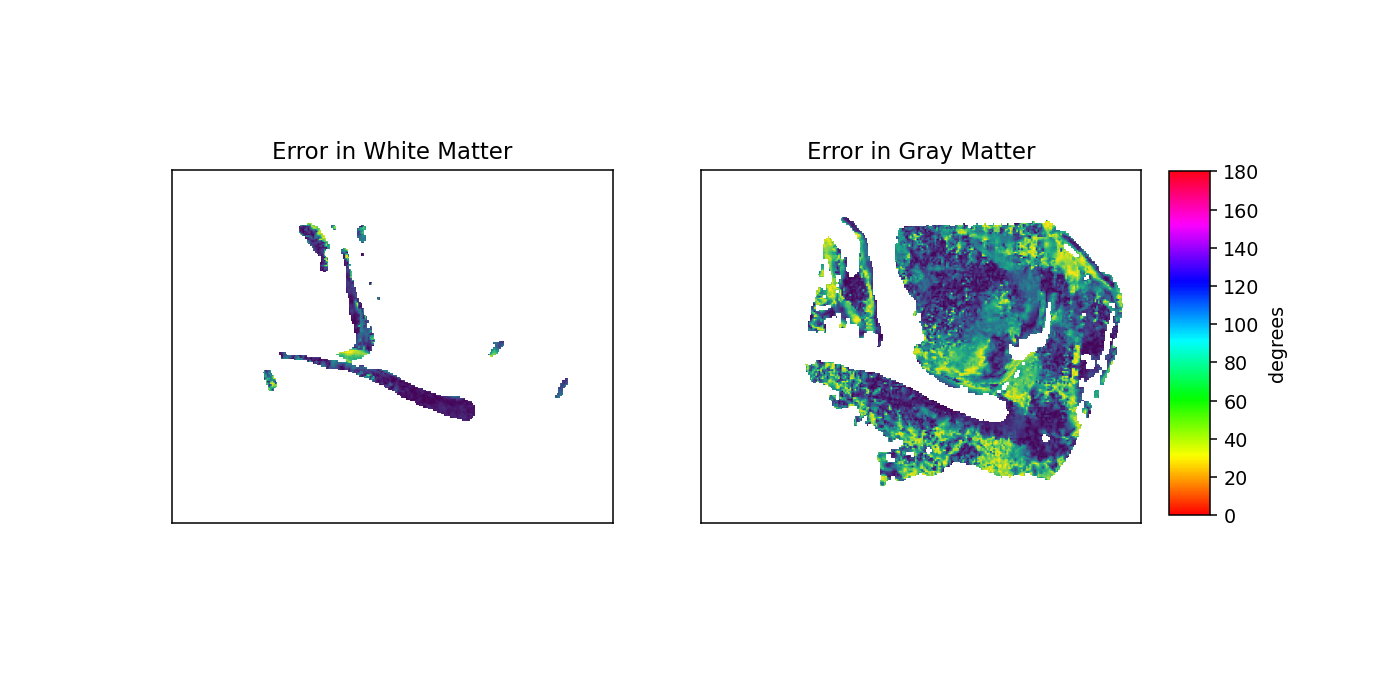

In [54]:
fig, axs = plt.subplots(1,2,sharex=True, figsize=(10,5))
slice=175
toshow1 = np.array(agreement_WM_in[slice])
toshow1[np.logical_not(WM_in[slice])] = np.nan
img = axs[0].imshow(toshow1, vmin=0, vmax=90)#, cmap='gray')
axs[0].set_title('Error in White Matter')

axs[0].set_xticks([])
axs[0].set_xticklabels([])
axs[0].set_yticks([])
axs[0].set_yticklabels([])

toshow2 = np.array(agreement_GM_in[slice])
toshow2[np.logical_not(GM_in[slice])] = np.nan
axs[1].imshow(toshow2, vmin=0, vmax=90)#, cmap='gray')
axs[1].set_title('Error in Gray Matter')

axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
plt.colorbar(img, cax=cbar_ax, label='degrees')

plt.savefig('error_WM-GM.png')

# fname = 'error_WM_color.png'
# out = '../outputs/'
# plt.imsave(os.path.join(out,fname),np.array(toshow1), vmin=np.min(agreement_WM_in[slice]), vmax=np.max(agreement_WM_in[slice]))#, cmap='gray')

# fname = 'error_GM_color.png'
# out = '../outputs/'
# plt.imsave(os.path.join(out,fname),np.array(toshow2), vmin=np.min(agreement_GM_in[slice]), vmax=np.max(agreement_GM_in[slice]))#, cmap='gray')



In [55]:
brain_mask_nan = np.array(brain_mask)
brain_mask_nan[np.logical_not(brain_mask_nan)] = np.nan
st_angles_brain = st_angles * brain_mask_nan
st_angles_WM_in = st_angles * WM_in
st_angles_GM_in = st_angles * GM_in
dti_angles_brain = dti_angles * brain_mask_nan
dti_angles_WM_in = dti_angles * WM_in
dti_angles_GM_in = dti_angles * GM_in

<IPython.core.display.Javascript object>


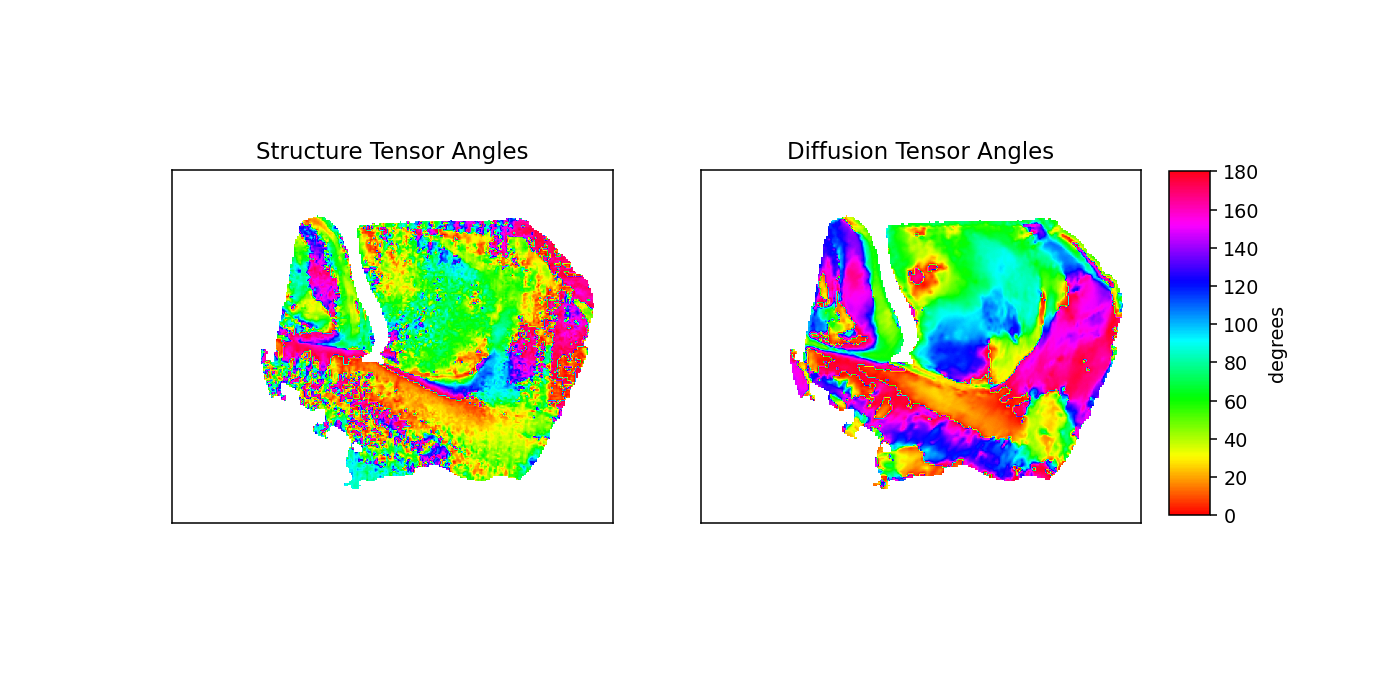

In [61]:
toshow = np.array(dti_angles[slice]*180/np.pi)
toshow[np.logical_not(brain_mask[slice])] = np.nan
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))
img = axs[1].imshow(toshow, vmin=0, vmax=180, cmap='hsv')
axs[1].set_title('Diffusion Tensor Angles')
axs[1].set_xticks([])
axs[1].set_xticklabels([])
axs[1].set_yticks([])
axs[1].set_yticklabels([])
# plt.savefig('/home/brysongray/dti_validate/outputs/dti_angles_hsv_plot')

toshow = np.array(st_angles[slice]*180/np.pi)
toshow[np.logical_not(brain_mask[slice])] = np.nan
axs[0].imshow(toshow, vmin=0, vmax=180, cmap='hsv')
axs[0].set_title('Structure Tensor Angles')
axs[0].set_xticks([])
axs[0].set_xticklabels([])
axs[0].set_yticks([])
axs[0].set_yticklabels([])

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
plt.colorbar(img, cax=cbar_ax, label='degrees')

plt.savefig('/home/brysongray/dti_validate/outputs/st-dti_angles_hsv_plot')



# construct orientation-anisotropy-intenity hsv images

In [ ]:
# construct orientation-anisotropy-intenity hsv images
# for dwi
print(FA_small.shape)
print(dti_angles.shape)
print(I.shape)
dti_angles_scaled = dti_angles / np.max(dti_angles)
I_scaled = I[0] / np.max(I[0])
dti_hsv = np.stack((dti_angles_scaled, FA_small, I_scaled), axis=-1)#.transpose(-1,0,1,2)

In [ ]:
dti_rgb.shape

In [ ]:
plt.figure()
plt.imshow(dti_hsv[slice], cmap='hsv')

In [ ]:
# now histology

imfile = '/home/brysongray/data/human_amyg/histology/MD847-My86-2021.12.14-09.16.22_MD847_1_0256_lossy.jp2'
J = cv2.imread(imfile, cv2.IMREAD_GRAYSCALE)


In [ ]:
img_down = 2
J = resize(J, (J.shape[0]//img_down, J.shape[1]//img_down), anti_aliasing=True)

In [ ]:
Jshape = J.shape

In [ ]:
fname = st_list_x[slice]
with h5py.File(os.path.join(st_path,fname),'r') as f:
    img = f[list(f.keys())[0]][:]
# combine 2x2 structure tensors into one dimension (xx,xy,yy)
# note structure tensors are saved in xy not row-column format I will change back to row-column here
S_ = np.stack((img[...,1,1], img[...,0,1], img[...,0,0]))

In [ ]:
S_.shape

In [ ]:
del J

In [ ]:
# resize
S_large = resize(S_, (3, Jshape[0], Jshape[1]), anti_aliasing=True)


In [ ]:
np.savez('s_large.npz', S_large)

In [ ]:
S_large = np.load('s_large.npz')['arr_0']
# reshape
print('Stacking...')
S_large = np.stack((S_large[0], S_large[1], S_large[1], S_large[2]), axis=-1)
print('Reshaping...')
S_large = S_large.reshape(S_large.shape[:2] + (2,2))

In [ ]:
S_large.shape
np.savez('s_large.npz', S_large)

In [ ]:
# get principle orientations
w,e = np.linalg.eigh(S_large)
# st_eig_ = e[...,0] # this is the eigenvector corresponding to the smallest eigenvalue
# st_angles_ = np.arctan(st_eig_[...,0]/st_eig_[...,1]) # arctan(row/column)

In [ ]:
st_eig = e[...,0] # this is the eigenvector corresponding to the smallest eigenvalue
np.savez('st_eig_large.npz', st_eig)

In [ ]:
st_angles = np.arctan(st_eig[...,0]/st_eig[...,1]) # arctan(row/column)
st_angles = np.where(st_angles < 0, st_angles + np.pi, st_angles) # make between 0 and pi
print(f'st_angles are between: {np.min(st_angles)} and {np.max(st_angles)}')

In [ ]:
np.savez('st_angles_large.npz', st_angles)

In [ ]:
st_angles = np.load('st_angles_large.npz')['arr_0']
print(st_angles.shape)

In [ ]:
st_angles_bins = np.zeros((st_angles.shape[0]//117, st_angles.shape[1]//101, 117*101))
for i in range(216):
    for j in range(269):
        st_angles_bins[i,j] = np.ravel(st_angles[i*117:i*117+117,j*101:j*101+101])

In [ ]:
np.savez('st_angles_bins.npz', st_angles_bins)

In [ ]:
# fit bins [111:114, 120:123] to fourier bases
bins = st_angles_bins[101:104,67:71]
bins = bins.reshape((-1,bins.shape[-1]))
Ntheta = 500
t = np.arange(Ntheta+1)*(2*np.pi/Ntheta) - np.pi # -pi to pi
cf = []
for x in bins:
    x_flip = [theta-np.pi for theta in x]
    X = np.concatenate((x,x_flip))
    hist,_ = np.histogram(X, bins=t)
    xf = np.fft.rfft(hist)
    xfinv = np.fft.irfft(xf[:10],Ntheta+1)
    xfinv = xfinv / np.sum(xfinv)
    cf.append(xfinv)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, subplot_kw={'projection':'polar'}, linewidth=3.0)
for i,ax in enumerate(axs.flat):
    ax.plot(t,cf[i])
    ax.axis('off')
plt.savefig('cf_patch1.png')

In [ ]:
cf_patch = plt.imread('cf_patch1.png')[...,:3]
cf_patch = np.where(cf_patch == [1.,1.,1.], [np.nan,np.nan,np.nan], cf_patch)

In [ ]:
plt.imsave('cf_patch_clear.png',cf_patch)

In [ ]:
angles_rgb = np.load('/home/brysongray/dti_validate/angles_rgb_slice_256.npy')

In [ ]:
print(111*117)
print(120*101)
print(5200/117)
print(3300/101)

In [ ]:
rgb_patch = angles_rgb[44*117:47*117, 32*101:35*101]
plt.figure()
plt.imshow(rgb_patch)
plt.axis('off')
plt.savefig('rgb_patch.png')

In [ ]:
# rgb_patch = angles_rgb[111*117:114*117, 120*101:123*101]
plt.figure()
plt.imshow(angles_rgb)
plt.axis('off')

In [ ]:
 AI = abs(w[...,0] - w[...,1]) / abs(w[...,0] + w[...,1])

In [ ]:
out = '/home/brysongray/dti_validate/sta_slice_256.npz'
np.savez(out, J=J, S=S_large, st_angles=st_angles_, AI=AI)

In [ ]:
AI.shape

In [ ]:
st_angles_ = st_angles_ / np.pi
hsv = hsv2rgb(np.stack((st_angles_, AI, J), axis=-1))

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.imshow(dti_angles_WM_in[slice]*180/np.pi, vmin=0, vmax=180, cmap='twilight_shifted')
plt.colorbar()
plt.title('diffusion tensor angles at WM + in-plane')
fig = plt.figure(figsize=(12,12))
plt.imshow(st_angles_WM_in[slice]*180/np.pi, vmin=0, vmax=180, cmap='twilight_shifted')
plt.colorbar()
plt.title('structure tensor at WM + in-plane')

In [ ]:
from skimage.transform import resize

def plot_quiver(v, theta, density=.125):
    # plot directions as vector field
    fig = plt.figure(frameon=False, figsize=(8,8))
    v_ = resize(v, (v.shape[0]*density, v.shape[1]*density, v.shape[2]), anti_aliasing=True)
    theta_ = resize(theta, (theta.shape[0]*density, theta.shape[1]*density), anti_aliasing=True)
    x,y = np.meshgrid(np.arange(v_.shape[1]), np.arange(v_.shape[0])[::-1])
    extent = np.min(x), np.max(x), np.min(y), np.max(y)
    ax = fig.add_subplot(111)
    ax.quiver(x, y, v_[...,1], v_[...,0], angles='xy', scale_units='xy', scale=1, headwidth=0.01, headlength=0.01)
    ax.imshow(theta, cmap='hsv', alpha=0.3, interpolation='bilinear', extent=extent)
    return fig

In [ ]:
# st_eig_show = st_eig[slice]
# st_eig_show[np.logical_not(brain_mask[slice])] = np.nan
# st_angles_WM_in_show = st_angles_WM_in[slice]
# st_angles_WM_in_show[np.logical_not(brain_mask[slice])] = np.nan
# st_glyphs = plot_quiver(st_eig_show,st_angles_WM_in_show, density=.5)
st_glyphs = plot_quiver(st_eig[slice],st_angles_WM_in[slice], density=.5)

In [ ]:
st_glyphs.savefig('output_images/st_glyphs.png')

In [ ]:
dti_glyphs = plot_quiver(dti_eig_small[135,...,1:],dti_angles_WM_in[135], density=.5)

In [ ]:
dti_glyphs.savefig('output_images/dti_glyphs.png')

In [ ]:
dti_angles_90 = dti_angles + np.pi/2
dti_angles_90 = np.where(dti_angles_90 > np.pi, dti_angles_90 - np.pi, dti_angles_90)
dti_angles_90_WM = dti_angles_90 * WM_mask

In [ ]:
print(np.min(dti_angles_90))
print(np.max(dti_angles_90))

In [ ]:
plt.imshow(dti_angles_90_WM[138], vmin=0, vmax=np.pi, cmap='rainbow')

In [ ]:
dti_angles_270 = dti_angles + 3*np.pi/2
dti_angles_270 = np.where(dti_angles_270 > np.pi, dti_angles_270 - np.pi, dti_angles_270)
dti_angles_270_WM = dti_angles_270 * WM_mask

In [ ]:
plt.imshow(dti_angles_270_WM[138], vmin=0, vmax=np.pi, cmap='rainbow')

In [ ]:
print(np.min(st_angles))
print(np.max(st_angles))

In [ ]:
print(np.min(dti_angles))
print(np.max(dti_angles))

In [ ]:
def angle_comparison(imageA, imageB):
    diff = imageA - imageB
    avg = np.mean(diff)
    std = np.std(diff)
    
    return avg, std

In [ ]:
avg0,std0 = angle_comparison(dti_angles_WM, st_angles_WM)
avg90,std90 = angle_comparison(dti_angles_90_WM, st_angles_WM)
avg270,std270 = angle_comparison(dti_angles_270_WM, st_angles_WM)

In [ ]:
print(avg0,'\n',avg90,'\n',avg270)

In [ ]:
print(std0,'\n',std90,'\n',std270)